# LIBRARY 

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN

# DATA

In [2]:
import pandas as pd
data = pd.read_csv('../data/fetal_health.csv')

# DATA EXPLORATION

In [13]:
# Data Exploration
print("Shape of data:", data.shape)
print(data.head())
print(data.info())
print(data.describe())
print("Class distribution:")
print(data.iloc[:, -1].value_counts())

Shape of data: (2126, 22)
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0       

# PREPROCESSING

In [17]:
# Preprocessing
# Assuming the last column is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Encode labels to ensure 0-based indexing
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE-ENN to handle imbalanced data (only on training set to avoid data leakage)
smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

# Normalize features (fit on resampled training data, transform test data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training data shape after SMOTE-ENN:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Class distribution after SMOTE-ENN:")
print(pd.Series(y_train).value_counts())

Training data shape after SMOTE-ENN: (3632, 21)
Test data shape: (426, 21)
Class distribution after SMOTE-ENN:
2    1284
1    1253
0    1095
Name: count, dtype: int64


# Eksperimen Perbandingan Konfigurasi Model

In [18]:
# Eksperimen Perbandingan Konfigurasi Model
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report

# Daftar konfigurasi untuk eksperimen
optimizers = ['adam', 'sgd', 'rmsprop']
activations = ['relu', 'tanh', 'sigmoid']

# Simpan hasil eksperimen
results = []

for opt in optimizers:
    for act in activations:
        print(f"\n--- Eksperimen: Optimizer={opt}, Activation={act} ---")
        
        # Buat model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(X_train.shape[1],)),
            layers.Dense(16, activation=act),
            layers.Dense(len(np.unique(y)), activation='softmax')
        ])
        
        # Compile model
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        
        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        # Compute predictions and classification report
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        report = classification_report(y_test, y_pred_classes, output_dict=True)
        
        # Extract macro averages
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1_score = report['macro avg']['f1-score']
        
        # Simpan hasil
        results.append({
            'optimizer': opt,
            'activation': act,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'history': history.history
        })
        
        print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


--- Eksperimen: Optimizer=adam, Activation=relu ---
Test Accuracy: 0.8357, Precision: 0.7287, Recall: 0.8354, F1-Score: 0.7597

--- Eksperimen: Optimizer=adam, Activation=tanh ---
Test Accuracy: 0.8357, Precision: 0.7287, Recall: 0.8354, F1-Score: 0.7597

--- Eksperimen: Optimizer=adam, Activation=tanh ---
Test Accuracy: 0.8169, Precision: 0.6834, Recall: 0.8085, F1-Score: 0.7224

--- Eksperimen: Optimizer=adam, Activation=sigmoid ---
Test Accuracy: 0.8169, Precision: 0.6834, Recall: 0.8085, F1-Score: 0.7224

--- Eksperimen: Optimizer=adam, Activation=sigmoid ---
Test Accuracy: 0.8052, Precision: 0.6642, Recall: 0.8077, F1-Score: 0.7058

--- Eksperimen: Optimizer=sgd, Activation=relu ---
Test Accuracy: 0.8052, Precision: 0.6642, Recall: 0.8077, F1-Score: 0.7058

--- Eksperimen: Optimizer=sgd, Activation=relu ---
Test Accuracy: 0.8005, Precision: 0.6702, Recall: 0.7869, F1-Score: 0.6981

--- Eksperimen: Optimizer=sgd, Activation=tanh ---
Test Accuracy: 0.8005, Precision: 0.6702, Recall

# EVALUATING

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.4539 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.4539 
Test accuracy: 0.8450704216957092
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepTest accuracy: 0.8450704216957092
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       333
           1       0.54      0.92      0.68        64
           2       0.66      0.79      0.72        29

    accuracy                           0.85       426
   macro avg       0.73      0.85      0.77       426
weighted avg       0.90      0.85      0.86       426
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       333
           1       0.54      0.92      0.68        64
           2       0.66      0.79      0.72        29

    accuracy                           0.85       426
   macro avg   

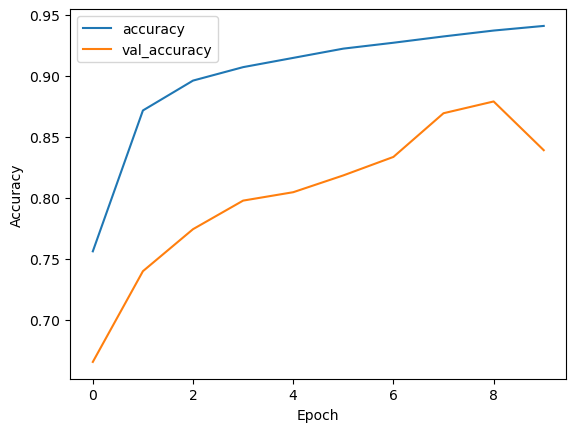

In [19]:
# Evaluating
# Evaluating the best model
# Rebuild the best model
best_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation=best_config['activation']),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

best_model.compile(optimizer=best_config['optimizer'],
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train the best model
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Tabel Performa Model:
  optimizer activation  test_accuracy  test_loss  precision    recall  \
0      adam       relu       0.835681   0.433090   0.728736  0.835441   
1      adam       tanh       0.816901   0.459238   0.683418  0.808525   
2      adam    sigmoid       0.805164   0.456927   0.664162  0.807727   
3       sgd       relu       0.800469   0.497888   0.670244  0.786867   
4       sgd       tanh       0.807512   0.515091   0.671240  0.815014   
5       sgd    sigmoid       0.776995   0.655213   0.724250  0.697068   
6   rmsprop       relu       0.838028   0.467697   0.715272  0.836442   
7   rmsprop       tanh       0.835681   0.460836   0.710839  0.827026   
8   rmsprop    sigmoid       0.805164   0.478391   0.668463  0.811934   

   f1_score  
0  0.759741  
1  0.722377  
2  0.705788  
3  0.698060  
4  0.714794  
5  0.658166  
6  0.754092  
7  0.748318  
8  0.709377  


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23720\4218269582.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


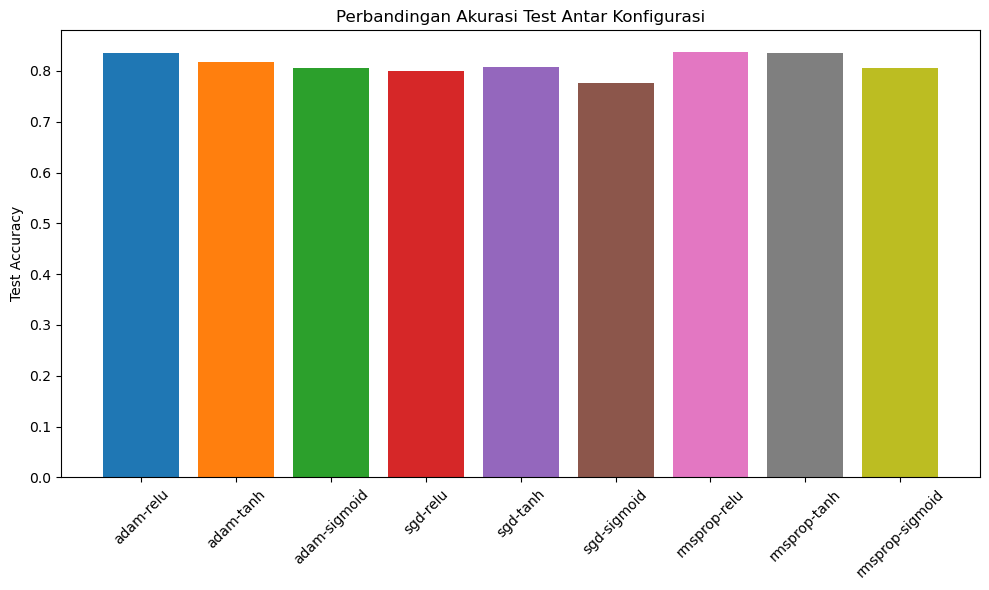


Konfigurasi Terbaik: Optimizer=rmsprop, Activation=relu, Accuracy=0.8380, Precision=0.7153, Recall=0.8364, F1-Score=0.7541


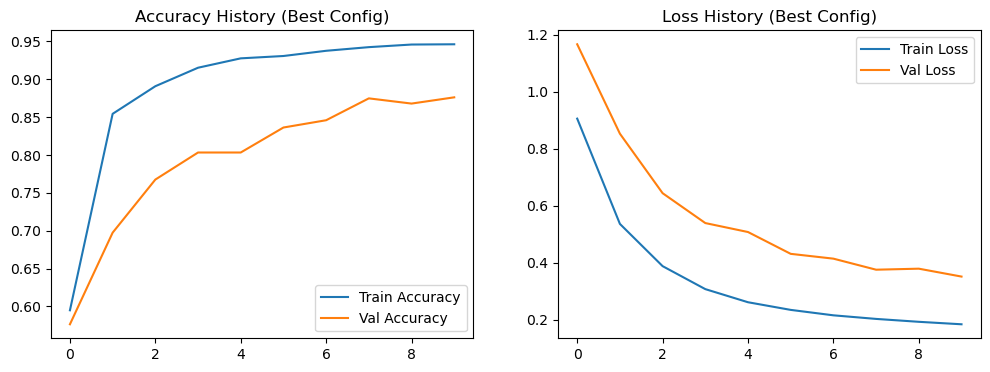

In [20]:
# Pelaporan Performa Eksperimen
import pandas as pd
import matplotlib.pyplot as plt

# Buat DataFrame dari hasil
df_results = pd.DataFrame(results)
print("Tabel Performa Model:")
print(df_results[['optimizer', 'activation', 'test_accuracy', 'test_loss', 'precision', 'recall', 'f1_score']])

# Plot perbandingan akurasi
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in df_results.iterrows():
    label = f"{row['optimizer']}-{row['activation']}"
    ax.bar(label, row['test_accuracy'], label=label)

ax.set_ylabel('Test Accuracy')
ax.set_title('Perbandingan Akurasi Test Antar Konfigurasi')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# Plot loss untuk konfigurasi terbaik (opsional)
best_idx = df_results['test_accuracy'].idxmax()
best_config = df_results.iloc[best_idx]
print(f"\nKonfigurasi Terbaik: Optimizer={best_config['optimizer']}, Activation={best_config['activation']}, Accuracy={best_config['test_accuracy']:.4f}, Precision={best_config['precision']:.4f}, Recall={best_config['recall']:.4f}, F1-Score={best_config['f1_score']:.4f}")

# Plot history untuk konfigurasi terbaik
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
plt.show()

# REPORT

Optimizer,Activation,Test Accuracy,Test Loss,Precision,Recall,F1-Score
adam,relu,0.8357,0.4331,0.7287,0.8354,0.7597
adam,tanh,0.8169,0.4592,0.6834,0.8085,0.7224
adam,sigmoid,0.8052,0.4569,0.6642,0.8077,0.7058
sgd,relu,0.8005,0.4979,0.6702,0.7869,0.6981
sgd,tanh,0.8075,0.5151,0.6712,0.8150,0.7148
sgd,sigmoid,0.7770,0.6552,0.7243,0.6971,0.6582
rmsprop,relu,0.8380,0.4677,0.7153,0.8364,0.7541
rmsprop,tanh,0.8357,0.4608,0.7108,0.8270,0.7483
rmsprop,sigmoid,0.8052,0.4784,0.6685,0.8119,0.7094

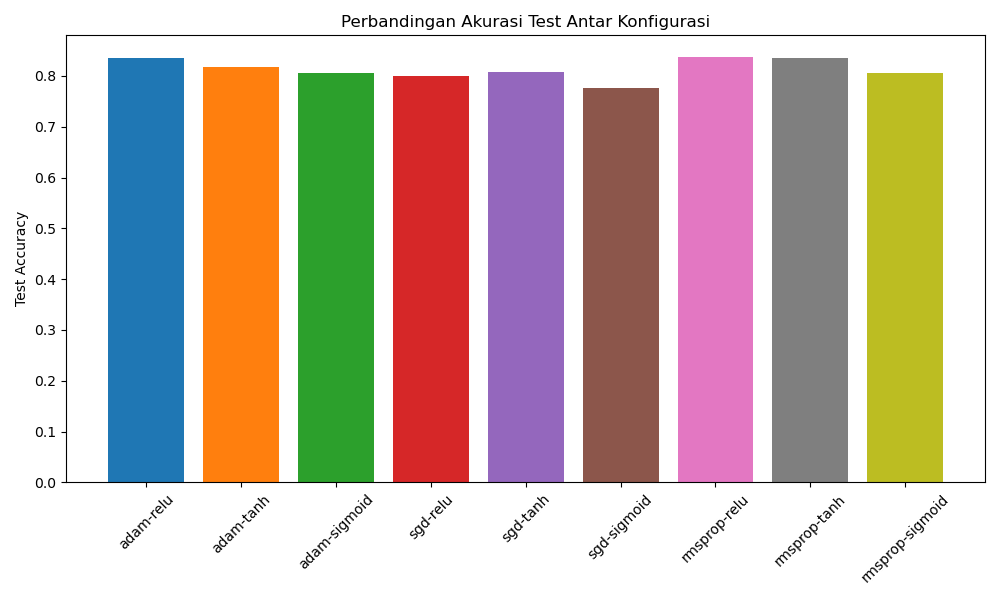
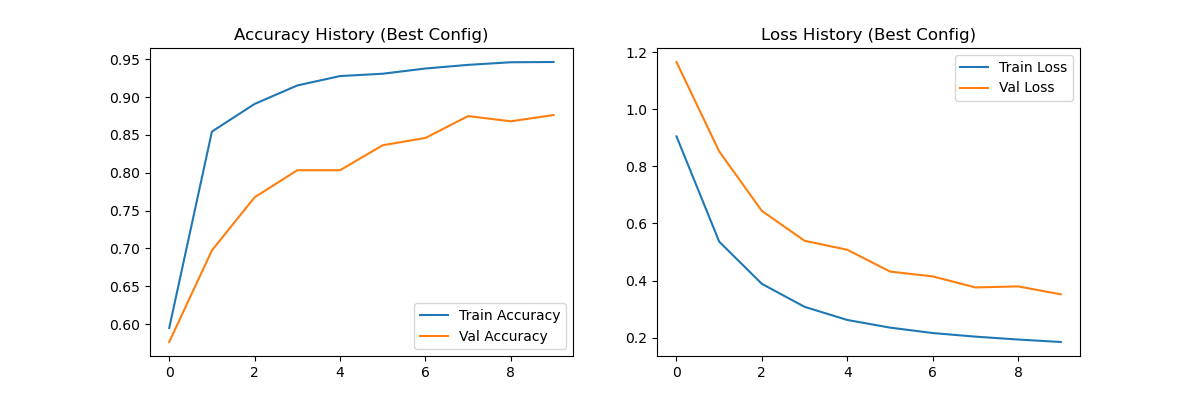

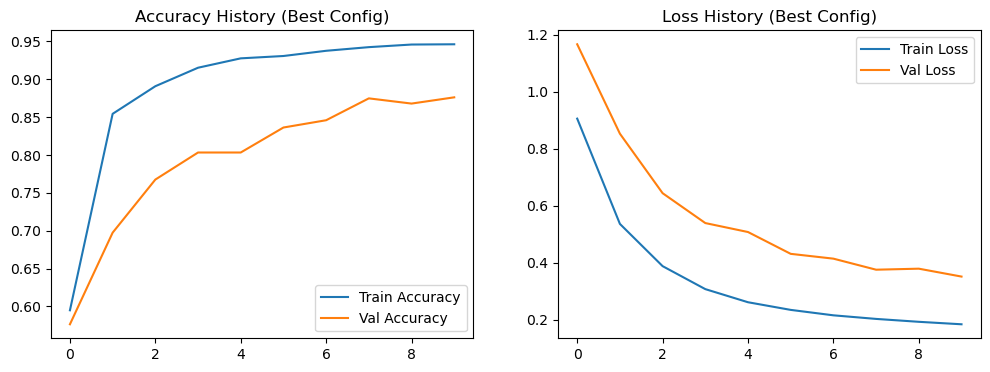

In [21]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import io
import base64

# Fungsi untuk mengkonversi plot ke base64
def plot_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return f"data:image/png;base64,{image_base64}"

# Buat HTML laporan
html = """
<h1>Laporan Hasil Klasifikasi</h1>

<h2>Arsitektur Model</h2>
<p>Model menggunakan arsitektur Sequential dengan layer-layer berikut:</p>
<ul>
    <li>Input(shape=(X_train.shape[1],))</li>
    <li>Dense(16, activation=activation_function)</li>
    <li>Dense(len(np.unique(y)), activation='softmax')</li>
</ul>

<h2>Parameter yang Dicoba</h2>
<p>Eksperimen dilakukan dengan kombinasi parameter berikut:</p>
<ul>
    <li><strong>Optimizer:</strong> adam, sgd, rmsprop</li>
    <li><strong>Activation Function:</strong> relu, tanh, sigmoid</li>
    <li><strong>Epochs:</strong> 10</li>
    <li><strong>Batch Size:</strong> 32</li>
    <li><strong>Validation Split:</strong> 0.2</li>
</ul>

<h2>Hasil Setiap Percobaan</h2>
<table border="1" style="border-collapse: collapse; width: 100%;">
    <tr>
        <th>Optimizer</th>
        <th>Activation</th>
        <th>Test Accuracy</th>
        <th>Test Loss</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1-Score</th>
    </tr>
"""

for _, row in df_results.iterrows():
    html += f"""
    <tr>
        <td>{row['optimizer']}</td>
        <td>{row['activation']}</td>
        <td>{row['test_accuracy']:.4f}</td>
        <td>{row['test_loss']:.4f}</td>
        <td>{row['precision']:.4f}</td>
        <td>{row['recall']:.4f}</td>
        <td>{row['f1_score']:.4f}</td>
    </tr>
"""

html += """
</table>

<h2>Konfigurasi Terbaik</h2>
<p>Konfigurasi terbaik berdasarkan test accuracy tertinggi:</p>
<ul>
    <li><strong>Optimizer:</strong> """ + str(best_config['optimizer']) + """</li>
    <li><strong>Activation:</strong> """ + str(best_config['activation']) + """</li>
    <li><strong>Test Accuracy:</strong> """ + f"{best_config['test_accuracy']:.4f}" + """</li>
    <li><strong>Test Loss:</strong> """ + f"{best_config['test_loss']:.4f}" + """</li>
    <li><strong>Precision:</strong> """ + f"{best_config['precision']:.4f}" + """</li>
    <li><strong>Recall:</strong> """ + f"{best_config['recall']:.4f}" + """</li>
    <li><strong>F1-Score:</strong> """ + f"{best_config['f1_score']:.4f}" + """</li>
</ul>

<h2>Grafik Perbandingan Akurasi</h2>
<img src=\"""" + plot_to_base64(fig) + """\" alt="Perbandingan Akurasi" style="width:100%; max-width:800px;">

<h2>History Training untuk Konfigurasi Terbaik</h2>
"""

# Buat plot history lagi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
history_fig = plt.gcf()
html += """<img src=\"""" + plot_to_base64(history_fig) + """\" alt="History Training" style="width:100%; max-width:800px;">"""

html += """
</body>
</html>
"""

display(HTML(html))

In [22]:
# simpan laporan ke file HTML
with open('report_fetal_v2.html', 'w') as f:
    f.write(html)